In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Machine Learning & Deep Learning
## Session 19a: SARSA

##  Frozen Lake Problem
    
<img src='../../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

### State Action Reward State Action (SARSA) 

As indicated by the name SARSA, it updates the $Q(s_{t}, a_{t})$, according to the current state $s_{t}$, the action choose $a_{t}$, the reward $r_{t}$ due to this action, the new state $s_{t+1}$ after taking this action, and the action $a_{t+1}$ picked for this new state.
Given that, the Q-value table can be updated by:

$$Q(s_{t}, a_{t}) \leftarrow Q(s_{t}, a_{t}) + \alpha[r_{t} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_{t}, a_{t})]$$

where, $\alpha$ stands for the learning rate and $\gamma$ represents the discount factor. It can be seen in the definition that the SARSA method aims to update the policy through interactions with the environment, so it belongs to the on-policy learning algorithm family.

In [2]:
# import statements
import gymnasium as gym
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange

from IPython.display import clear_output, display

from time import sleep
import torch as T
#from helper import ,moving_average
#from deep_q_network import DeepNetwork
#from replay_memory import ReplatBuffer

%matplotlib inline
plt.style.use('ggplot')

C:\Users\duasp\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
def to_onehot(size,value):
    """1 hot encoding for observed state"""
    return np.eye(size)[value]

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=np.float32)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [4]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        #self.state_memory = np.zeros((self.mem_size, *input_shape),
        #                             dtype=np.float32)
        self.state_memory = np.zeros((self.mem_size, input_shape),
                                     dtype=np.float32)
        #self.new_state_memory = np.zeros((self.mem_size, *input_shape),
        #                                 dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, input_shape),
                                         dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool_)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

In [5]:
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class DeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, name, input_dims, model_dir):
        super(DeepQNetwork, self).__init__()
        self.model_dir = model_dir
        self.model_file = os.path.join(self.model_dir, f'{name}.pt')

        self.fc1 = nn.Linear(input_dims, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256,n_actions)

        self.optimizer = optim.RMSprop(self.parameters(), lr=lr)

        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)


    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        actions = self.fc5(x)

        return actions

    def save_checkpoint(self):
        #print('... saving checkpoint ...')
        T.save(self.state_dict(), self.model_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.model_file))

In [6]:
# Some basic parameters
inpDir = os.path.join( '..', 'input')
outDir = '../output'
modelDir = 'Neural Network'

RANDOM_STATE = 24

np.random.seed(RANDOM_STATE)

EPOCHS = 50   # number of cycles to run
ALPHA = 0.001
BATCH_SIZE = 32
TRAIN_SIZE = 0.8
IMG_HEIGHT = 188
IMG_WIDTH = 188


# Transformations
# flipping
FLIP_MODE = "horizontal_and_vertical"
# Rotation
ROTATION_FACTOR = (-0.1, 0.1)
# filling mode
FILL_MODE = 'nearest'


## Early Stopping
ES_PATIENCE = 20 # if performance does not improve stop
# Learning rates
LR_PATIENCE = 10 # if performace is not improving reduce alpha
LR_FACTOR = 0.5 # rate of reduction of alpha
PATIENCE = 5
# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (9, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

plt.rcParams.update(params)

EPISODES = 5000

# ALPHA = 0.01 #0.85
# GAMMA = 0.90
# EPSILON = 0.8

 ## Load Frozen Lake Environment

(-0.5, 511.5, 511.5, -0.5)

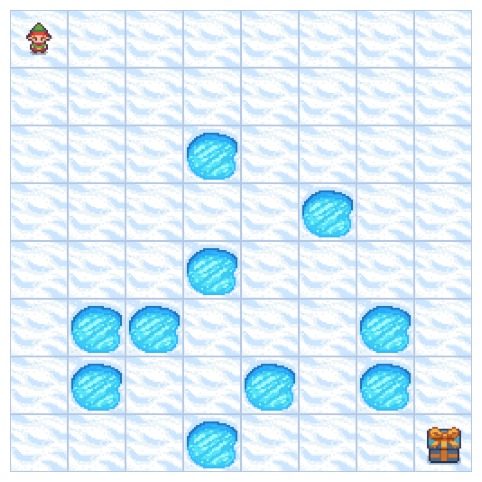

In [7]:
# Make the environment based on non-deterministic policy
#env = gym.make('FrozenLake8x8-v1', render_mode='rgb_array')

env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=True, render_mode='rgb_array')

GRID_SIZE = (8,8)

env.reset(seed = RANDOM_STATE)

img = plt.imshow(env.render())

plt.grid('off')

plt.axis(False)

## Environment - FrozenLake

Fronze Lake is a simple game where Actor is on a frozen lake and need to reach a **Goal** on the frozen lake. Some parts of lake are frozen solid and some parts have holes. If Actor walk into a hole, game over!

Actions: $A$ ={0,1,2,3}

    LEFT: 0
    DOWN = 1
    RIGHT = 2
    UP = 3

Whole lake is a 8 x 8 grid world. 
States $S$ are from 0 to 63

In [8]:
# Helper function to plot the grid

def fn_plot_heatmap(values, opt_policy):
    
    fig, ax = plt.subplots()
    
    act = [action_mappings[action] for action in np.argmax(opt_policy, axis=1)]
    
    labels = np.asarray(["{0}\n{1:.3f}".format(a, v)
                          for a, v in zip(act,values.ravel())]).reshape(8,8)

    sns.heatmap(values, annot=labels, fmt="", cmap='RdYlGn', ax=ax, cbar=False)
    
    plt.show()

In [9]:
# function to render environment in a nicer way!

def fn_render_env(env):
    
    fig, ax = plt.subplots()

    ax.imshow(env.render())
    
    ax.axis(False)
    
    plt.show()

In [10]:
# Action mappings - Map actions to numbers
action_mappings = {
    0: '\u2190' , # Left
    1: '\u2193', # Down
    2: '\u2192', # Right
    3: '\u2191', # Up
}

print (action_mappings)

{0: '←', 1: '↓', 2: '→', 3: '↑'}


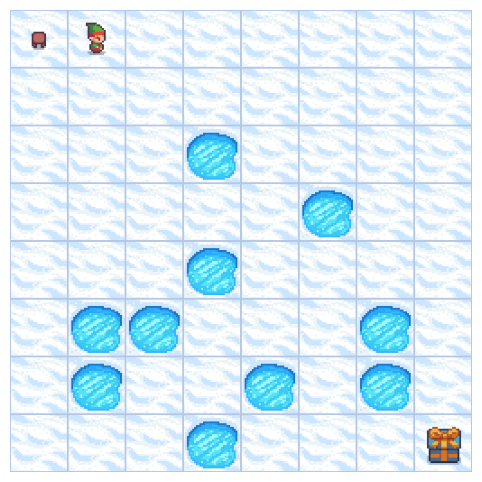

1 0.0 False False {'prob': 0.3333333333333333}


In [11]:
# Go right once (action = 2), we should go to the right but we did not!
env.reset()

action = 2

observation, reward, terminated, truncated, prob = env.step(action)

fn_render_env(env)

print (observation, reward, terminated, truncated, prob)

In [12]:
env.step(2)

(2, 0.0, False, False, {'prob': 0.3333333333333333})

In [13]:
input_dims = env.observation_space.n 
num_actions = env.action_space.n

lr = 0.0001 # learning rate
eps_min = 0.1 # epsilon greedy = best action
gamma = 0.99 # discount factor
eps_dec = 1e-4 # depreciation of epsilon
pretrained = False # are we using pretrained model
retrain = True
if pretrained:
    eps = 0.5
else:
    eps = 1.0

max_mem = 20000
batch_size = 32 
replace = 1000 # interval for replacing target network
algo = 'DQNAgent'

In [14]:
class DQNAgent(object):
    def __init__(self, env, gamma, epsilon, lr, n_actions, input_dims,
                 mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,
                 replace=1000, algo=None, model_dir=modelDir):
        '''
        Args:
            env: Gymnasium environment
            gamma: Discount factor
            epsilon: Factor for exploration
            lr: Learning rate
            n_actions: How many actions
            input_dims: Size of the environment
            mem_size: How many experiences to keep in memory
            batch_size: Batch size
            eps_min: minimum value of epsilon, Default=0.01 
            eps_dec:reduction factor for epsilon, Default=5e-7,
            replace: Frequency to replace =1000, 
            algo=None
            model_dir=modelDir
        
        '''
        # Instantiate the class
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.replace_target_cnt = replace
        self.algo = algo
        self.model_dir = model_dir
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0
        self.loss = []

        self.memory = ReplayBuffer(mem_size, input_dims, n_actions)

        # Evaluation network
        self.q_eval = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims = self.input_dims,
                                    name = self.env.spec.id+'_'+self.algo+'_q_eval',
                                    model_dir = self.model_dir)
            

        # target network
        self.q_next = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims,
                                    name=self.env.spec.id+'_'+self.algo+'_q_next',
                                    model_dir=self.model_dir)
        
        # Best weights
        self.q_best = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims,
                                    name=self.env.spec.id+'_'+self.algo+'_q_best',
                                    model_dir=self.model_dir)
        
        # Copy weights from Evaluation network
        self.q_next.load_state_dict(self.q_eval.state_dict())
        
        if pretrained:
            self.load_models()
        
        

    def choose_action(self, observation, evaluation = False):
        '''
        Args:
            observation: State as one hot encoded
            evaluation: bool: true when we are evaluating
        '''
        # are we evaluating
        if evaluation:
            
            self.q_best.eval()   # set in evaluation mode 
            state = T.tensor(observation, dtype=T.float).to(self.q_eval.device) #Convert to tensor
            actions = self.q_best.forward(state) # take a step forward on best values
            action = T.argmax(actions).item() # get action
        
        else:
            # for training; epsilon times take random action
            if np.random.random() > self.epsilon: # if it is more than epsilon
                state = T.tensor(observation, dtype=T.float ).to(self.q_eval.device) #Convert to tensor
                actions = self.q_eval.forward(state) # take a step forward on Eval network
                action = T.argmax(actions).item() # get action
            
            else:
                action = np.random.choice(self.action_space) # random action
        return action

    def store_transition(self, state, action, reward, state_, done):
        '''
        Args:
            state, action, reward, state_, done: output of taking one step in the environment
        '''
        self.memory.store_transition(state, action, reward, state_, done) # store in the memory for replay

    def sample_memory(self):
        '''
            Sample from the memory
            Return:
                A batch of:
                states: Current states
                actions: actions under current states:
                rewards: rewards for taking action
                states_: nest states:
                dones : Is next tate a terminal state
        '''
        state, action, reward, new_state, done = \
                                self.memory.sample_buffer(self.batch_size)

        states = T.tensor(state).to(self.q_eval.device) # Convert to tensor
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        states_ = T.tensor(new_state).to(self.q_eval.device)

        return states, actions, rewards, states_, dones

    def replace_target_network(self):
        '''
            If learn step counter is multiple of replacing value; 
            copy state dict of Eval network onto target network
        '''
        if self.learn_step_counter % self.replace_target_cnt == 0:
            #print('Replacing target network')
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                           if self.epsilon > self.eps_min else self.eps_min

    def save_models(self):
        self.q_eval.save_checkpoint()
        self.q_next.save_checkpoint()
        self.q_best.save_checkpoint()
        
    def load_models(self):
        print ('Loading Pretrained models...')
        self.q_eval.load_checkpoint()
        self.q_next.load_checkpoint()
        self.q_best.load_checkpoint()

    def learn(self):
        
        if self.memory.mem_cntr < self.batch_size: # no nothing if memory is smaller than batch
            return 0 # Returning 0 for loss 
        
        self.q_eval.train() # set train mode
        self.q_eval.optimizer.zero_grad() # reset optimizer

        self.replace_target_network() # call to replace network

        states, actions, rewards, states_, dones = self.sample_memory() # get a sample
        indices = np.arange(self.batch_size) # Create indices

        q_pred = self.q_eval.forward(states)[indices, actions] # get q values for every state under the action
        q_next = self.q_next.forward(states_).max(dim=1)[0] # get max value for next state

        q_next[dones] = 0.0 
        q_target = rewards + self.gamma*q_next # calculate TD target 

        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device) # calculate loss

        loss.backward()                                                  # Gradient descent
        self.q_eval.optimizer.step() # perform optimizer step
        self.learn_step_counter += 1 # increment counter for look for replacement of target network
        if self.learn_step_counter % 10 == 0: # reduce epsilon every 10th step
            self.decrement_epsilon()
        return loss.item()
        
    def replace_best_network(self):
        self.q_best.load_state_dict(self.q_eval.state_dict())

In [15]:
agent = DQNAgent(env = env,
                 gamma = gamma,
                 epsilon = eps,
                 lr = lr,
                 n_actions = num_actions,
                 input_dims = input_dims, 
                 mem_size = max_mem,
                 batch_size = batch_size,
                 algo = algo,
                 model_dir = modelDir)

In [16]:
agent.q_eval

DeepQNetwork(
  (fc1): Linear(in_features=64, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=4, bias=True)
  (loss): MSELoss()
)

In [17]:
if retrain:
    best_score = -np.inf
    
    history,scores = [],[]
    for i in range(EPISODES):
        state,info = env.reset()
        done = False
        n_step = 0
        score = 0
        t_loss = 0
        hist_dict = {}
        
        while not done:
            observation = to_onehot(input_dims,state).reshape(1,input_dims)
            action = agent.choose_action(observation)
            next_state,reward,terminated,truncated,transit_prob = env.step(action)
            
            done = terminated or truncated
            
            observation_ = to_onehot(input_dims,next_state).reshape(1,input_dims)
            
            score += reward
            
            agent.store_transition(observation,action,reward,observation_,done)
            
            loss = agent.learn()
            
            t_loss += loss
            state = next_state
            n_step += 1
        scores.append(score)
        hist_dict['loss'] = t_loss
        hist_dict['episode'] = i
        hist_dict['score'] = score
        hist_dict['epsilon'] = agent.epsilon
        avg_score = np.mean(scores[-100:])
        hist_dict['avg_score'] = avg_score
        history.append(hist_dict)
        
        if avg_score > best_score:
                print('episode: ', i,'score: ', score,' average score %.2f' % avg_score, 
                      'best score %.2f' % best_score, 'epsilon %.2f' % agent.epsilon, 
                      'steps', n_step)
                agent.replace_best_network()
                best_score = avg_score
    agent.save_models()

episode:  0 score:  0.0  average score 0.00 best score -inf epsilon 1.00 steps 27
episode:  228 score:  1.0  average score 0.01 best score 0.00 epsilon 1.00 steps 68


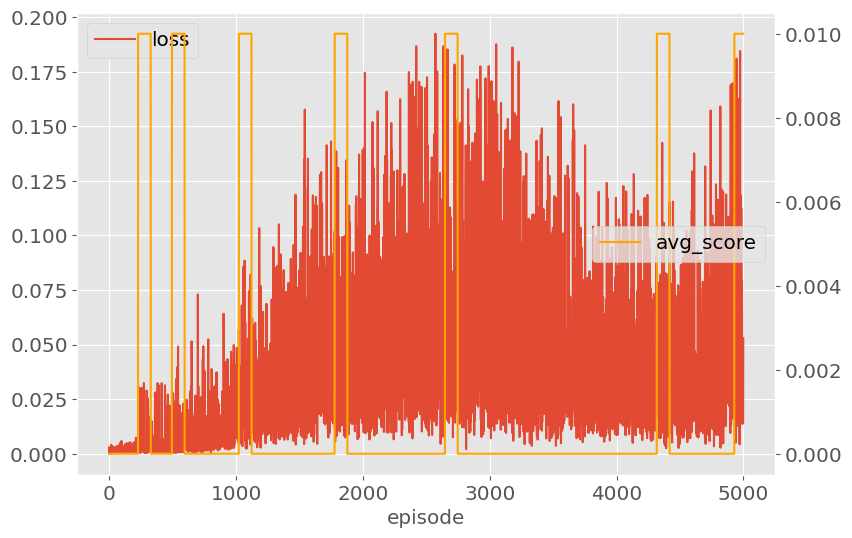

In [18]:
if retrain:
    hist_df = pd.DataFrame(history).set_index('episode')
    ax = hist_df.plot(y = 'loss')
    axt = ax.twinx()
    hist_df.plot(y = 'avg_score', ax = axt, c = 'Orange')
    axt.grid(False)

In [19]:
def fn_render_env(env, agent, episodes=10):
    rewards = []
    state, info = env.reset()
    img = plt.imshow(env.render())

    for episode in range(episodes):
        episode_reward = 0
        state, info = env.reset()
        done = False
        while not done:
            curr_state_encoded = to_onehot(input_dims, state).reshape(1, input_dims)
            # propose an action
            action = agent.choose_action(curr_state_encoded, evaluation = True)
            img.set_data(env.render()) 
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_reward+=reward
            img.set_data(env.render()) 
            plt.axis('off')
            plt.title(f'Episode: {episode}')
            display.display(plt.gcf())
            
            display.clear_output(wait=True)
            if done:
                #print (episode_reward)
                break
        rewards.append(episode_reward)
    env.close()
    return rewards

AttributeError: 'function' object has no attribute 'display'

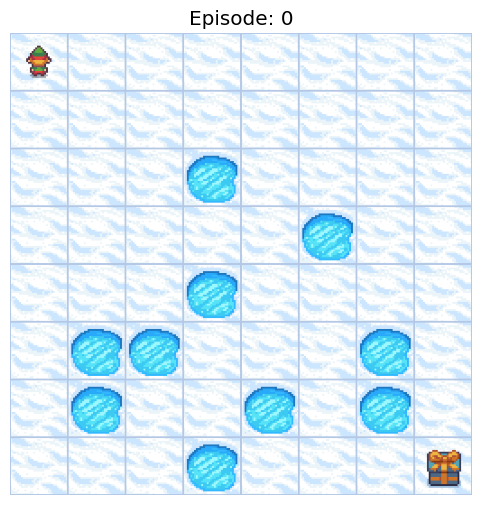

In [20]:
rewards = fn_render_env(env, agent, episodes=5)

In [ ]:
# Action mappings - Map actions to numbers
action_mappings = {
    0: '\u2190' , # Left
    1: '\u2193', # Down
    2: '\u2192', # Right
    3: '\u2191', # Up
}

print (action_mappings)

In [ ]:
def plot_value(env):
    state, _ = env.reset()

    curr_state_encoded = to_onehot(input_dims, state).reshape(1, input_dims)

    obs_sqr = int(np.sqrt(input_dims))

    initial_state = np.zeros((obs_sqr, obs_sqr))

    value_fn = np.zeros((obs_sqr, obs_sqr))

    labels = np.empty((obs_sqr, obs_sqr), dtype=object)

    for x in range(0, obs_sqr):
        for y in range(0, obs_sqr):
            my_state = initial_state.copy()

            my_state[x,y] = 1  # Place the player at a given X/Y location.

            # And now have the critic model predict the state value
            # with the player in that location.
            pred = agent.q_best(T.tensor(my_state.reshape(1, input_dims), dtype=T.float32, device=agent.q_best.device))
            value = T.max(pred).item()
            action = T.argmax(pred).item()
            value_fn[x,y] = value
            labels[x,y] = np.asarray("{0}\n{1:.2f}".format(action_mappings[action], value))
    fig, axes = plt.subplots(1,2)
    sns.heatmap(value_fn, annot=labels, fmt="", cmap='RdYlGn', ax=axes[0])
    axes[1].imshow(env.render())
    axes[1].grid(False)
    plt.show()

In [ ]:
plot_value(env)

In [ ]:
n_iteration = 1000

highscore = 0

data_row = []

for n_iter in tqdm(range(n_iteration)):

    points = 0 # keep track of the reward each episode
    
    data_dict = {}
    
    for i_episode in range(20): # run 20 episodes
        
        observation = env.reset()[0]
        
        while True: # run until episode is done
            curr_state_encoded = to_onehot(input_dims, observation).reshape(1, input_dims)
            
            action = agent.choose_action(curr_state_encoded, evaluation = True)
            
            observation, reward, terminated, truncated, info = env.step(action)
    
            points += reward
            
            done = terminated or truncated
            if done:
                #env.render()
                #print ('Iteration', n_iter, observation, reward, done, info)

                if points > highscore: # record high score
                    highscore = points
                break
    data_dict['run'] = n_iter
    data_dict['Points']=  points
    data_row.append(data_dict)

In [ ]:
results_df =  pd.DataFrame(data_row)
sns.set_theme(style="whitegrid")
ax = sns.violinplot(x=results_df["Points"])